In [1]:
import tensorflow as tf
import os
import cv2
import pickle


In [16]:
NORMAL = "data/chest_xray/train/NORMAL"
PNEUMONIA = "data/chest_xray/train/PNEUMONIA"

NORMAL_img = os.listdir(NORMAL)
PNEUMONIA_img = os.listdir(PNEUMONIA)
img_file = os.path.join(NORMAL, "IM-0115-0001.jpeg")
img = cv2.imread(img_file)
print(img.shape)
print(NORMAL_img[10:20])
# print(ud_img[:10])

SIZE = 180

(1858, 2090, 3)
['IM-0135-0001.jpeg', 'IM-0137-0001.jpeg', 'IM-0140-0001.jpeg', 'IM-0141-0001.jpeg', 'IM-0143-0001.jpeg', 'IM-0145-0001.jpeg', 'IM-0147-0001.jpeg', 'IM-0149-0001.jpeg', 'IM-0151-0001.jpeg', 'IM-0152-0001.jpeg']


In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(SIZE, SIZE, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 176, 176, 32)      2432      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 174, 174, 32)      9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 87, 87, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 85, 85, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 83, 83, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 41, 41, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 39, 39, 128)      

In [40]:

model.compile(optimizer="adam" , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# model.compile(optimizer=RMSprop(lr=0.001),
#               loss='binary_crossentropy',
#               metrics = ['accuracy'])

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_dir = "data/chest_xray"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode = 'nearest')
test_datagen  = ImageDataGenerator( rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode = 'nearest')

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    shuffle = True,
                                                    batch_size=20,
                                                    class_mode='sparse',
                                                    target_size=(SIZE, SIZE))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         shuffle = True,
                                                         batch_size=20,
                                                         class_mode  = 'sparse',
                                                         target_size = (SIZE, SIZE))

print(train_generator.class_indices)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


In [42]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=10,
                              verbose=1)

Epoch 1/10
261/261 [==============================] - 2435s 9s/step - loss: 0.6673 - accuracy: 0.7469 - val_loss: 0.9680 - val_accuracy: 0.5625
Epoch 2/10
261/261 [==============================] - 2490s 10s/step - loss: 0.4636 - accuracy: 0.7859 - val_loss: 4.6823 - val_accuracy: 0.5625
Epoch 3/10
204/261 [======================>.......] - ETA: 8:52 - loss: 0.4721 - accuracy: 0.7846

KeyboardInterrupt: 

# Visualization Intermediate Representation
### It will demonstrate what feature is extracted in every layer

c:\users\se7en\anaconda3\envs\kaif\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


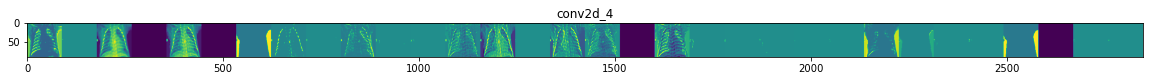

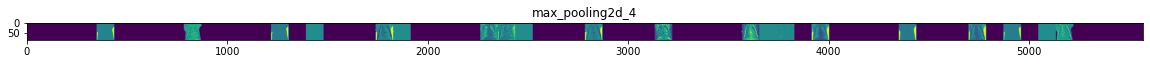

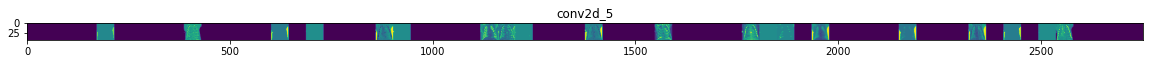

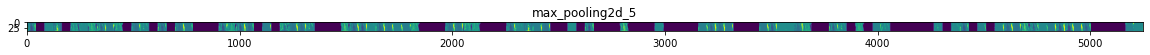

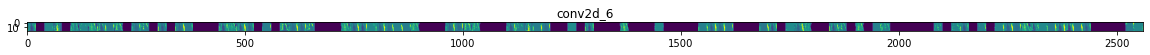

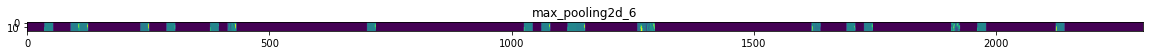

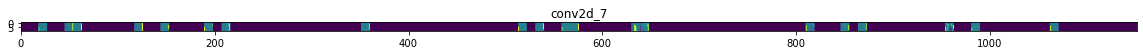

In [24]:
import matplotlib.pyplot as plt 
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image
NORMAL_files = [os.path.join(NORMAL, f) for f in NORMAL_img]
PNEUMONIA_files = [os.path.join(PNEUMONIA, f) for f in PNEUMONIA_img]

img_path = random.choice(NORMAL_files + PNEUMONIA_files)
img = load_img(img_path, target_size=(SIZE, SIZE))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (180, 180, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 180, 180, 3)

# Rescale by 1/255
x /= 255.0

# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    # Just do this for the conv / maxpool layers, not the fully-connected layers

    n_features = feature_map.shape[-1] 
    size       = feature_map.shape[ 1]  
    
    
    display_grid = np.zeros((size, size * n_features))
    

    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:,i * size:(i + 1)*size] = x

   
    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


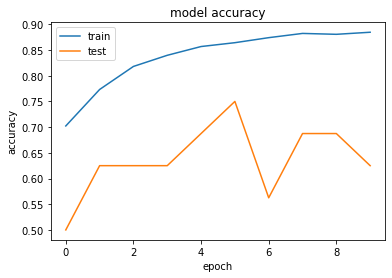

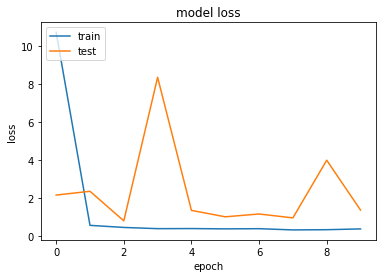

In [25]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
model.save('chest_xray_classifier.h5')